# Workshop name

**Author:** Verena Lachner, Martin Beneš

<div style="text-align: center">
<img src="https://www.uibk.ac.at/media/filer_public/00/c3/00c369ba-9e7a-42a4-9f73-466c81dc951a/universitaet-innsbruck-logo-cmyk-farbe.jpg" style="height: 5em; display: inline; padding-right: 2em" />
<img src="https://www.uncoverproject.eu/wp-content/uploads/2021/05/UNCOVER-Logog-440x92.5-final-1.0.png" style="height: 4em; display: inline; padding-left: 2em" />
</div>

<div style="text-align: center">
<a href="https://www.github.com/uibk-uncover/mip-stego-demo">
github.com/uibk-uncover/mip-stego-demo
</a>
</div>

## What is steganography?

### Steganography is the art and science of hiding a secret message in an inconspicuous cover object

Today, our cover object is a digital image

## Notebook setup

For this notebook, we will use a sample image `00001.tif` from ALASKA database. Run following code chunk to download it.

In [33]:
# download nockspitze from GitHub
import requests
res = requests.get(f'https://github.com/uibk-uncover/mip-stego-demo/raw/main/img/nockspitze.png')
with open('nockspitze.png', 'wb') as f:
    f.write(res.content)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.stats
import seaborn as sns
import string
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(threshold=99)
#plt.rcParams["figure.figsize"] = (12, 3)
np.random.seed(12345)  # for reproducibility
#
from matplotlib.pyplot import imshow, legend, ylim
from numpy import sum, histogram
from numpy.random import choice
from scipy.stats import chi2
from seaborn import histplot
#


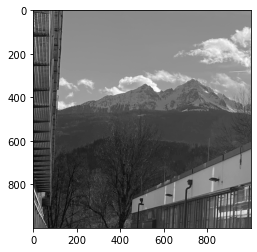

In [3]:
im = Image.open('../img/nockspitze.png')  # load image
cover = np.array(im.convert('L'))  # PIL to numpy
plt.imshow(cover,cmap = "gray");

## LSB Replacement Steganography

Idea: A human cannot distinguish between neighboring color values.

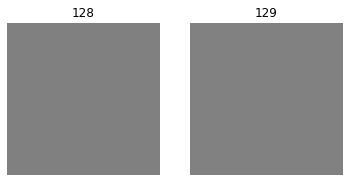

In [4]:
fig, ax = plt.subplots(1, 2, sharey=True)
for i, v in enumerate([0, 1]):
    ax[i].imshow([[128+v]], vmin=0, vmax=255, cmap='gray');
    ax[i].set_title(f'{128+v}');
    ax[i].axis('off');
    

Not even when they are joined together, really

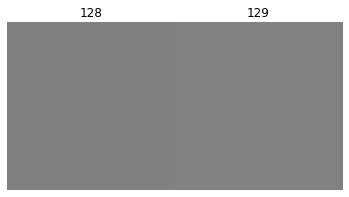

In [5]:
fig, ax = plt.subplots(1, 2, sharey=True)
for i, v in enumerate([0, 1]):
    ax[i].imshow([[128+v]], vmin=0, vmax=255, cmap='gray');
    ax[i].set_title(f'{128+v}');
    ax[i].axis('off');
    fig.subplots_adjust(wspace=0);

We will use that to hide our secret message

### A computer sees everything as 0s and 1s

| What we see      |     What a computer sees        |
|:----------------:|:-------------------------------:|
| "hi"             |     $01101000$ $01101001$       |
| $129$            |           $10000001$            |
| $128$            |           $10000000$            |

### Idea: Replace least significant bit (LSB) by message bit

In [6]:
from PIL import ImageDraw
from PIL import ImageFont

In [7]:
secret_message = "011010..."
print("secret message: " + secret_message)

secret message: 011010...


<center>
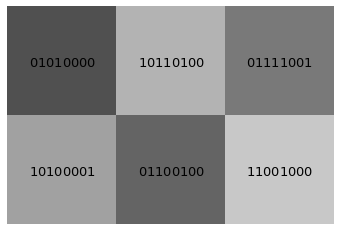
</center>

### Idea: Replace least significant bit (LSB) by message bit

In [9]:
from colorama import Fore, Style
print(f"secret message: {Fore.BLUE}0{Fore.RED}{Style.BRIGHT}1{Fore.GREEN}{Style.NORMAL}1{Fore.MAGENTA}{Style.BRIGHT}0{Fore.MAGENTA}{Style.NORMAL}1{Fore.RED}0{Style.RESET_ALL}...")

secret message: 011010...


<center>
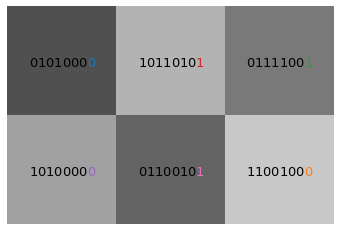
</center>

## How do we implement it?

## Real embedding

Pass the super secret message you want to embed.

In [11]:
# message

##In the following, we are generating a long message with random characters.
##Instead, you could simply give Python your own secret message as a String
#message = 'super secret secret!'

N = int(cover.size * .5) // 8 #This is how long we want our message to be
rng = np.random.default_rng(12345) 
message = ''.join(rng.choice(list(string.ascii_letters+string.digits), size=N))
len(message)

62500

Translate the message to 0s and 1s and add a stop code "000000000"

In [12]:
# encode
message_bits = []
for bit in message.encode('ascii') + b'\x00': # <- stop code
    for i in range(8):
        message_bits.append((bit >> i) & 1) # turn characters into 0s and 1s
message_bits = np.array(message_bits)
len(message_bits)

500008

We, for now, just want to embed the message sequentially starting from the first pixel

In [13]:
# set order
perm = np.linspace(0, cover.size-1, cover.size, dtype='int64')

Now, for each pixel, we replace its LSB by the respective message bit

In [14]:
# iterate elements
stego = cover.copy() #copy the cover

for i, it in enumerate(perm):
    # message exhausted (we are at end of message)
    if len(message_bits) <= i:
        break
        
    # get index (x- and y-coordinate of pixel we want to change)
    idx = it // cover.shape[1], it % cover.shape[1]
    
    # make change
    stego[idx] &= ~0 << 1
    stego[idx] |= message_bits[i]

We successfully embedded. 
As proof I will show you the difference between cover and stego image

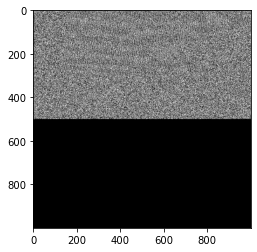

In [15]:
plt.imshow(cover != stego, vmin=0, vmax=1, cmap='gray');

## But we have a problem

Because we embedded sequentially into a very homogeneous region (the sky), 
our modifications are obvious if we look only into the LSB plane

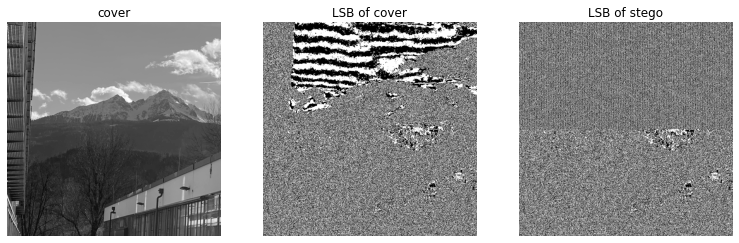

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(13, 13), sharey=False)

ax[0].imshow(cover, cmap = "gray");
ax[1].imshow(cover & 1, cmap = "gray");
ax[2].imshow(stego & 1, cmap = "gray");
ax[0].set_title(f'cover');
ax[1].set_title(f'LSB of cover');
ax[2].set_title(f'LSB of stego');
ax[0].axis('off');
ax[1].axis('off');
ax[2].axis('off');

How can we overcome this problem?

## By spreading our message bits out along a pseudorandom path

Pseudorandom means that something appears random,
but I can recreate the exact same thing if I know the seed/key with which it was created.

For example the landscape in minecraft is pseudorandom.

<center>
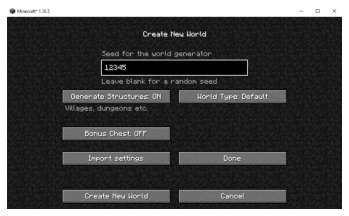
</center>

Now we can do switch out where we choose to embed.

In [18]:
# set order
perm = np.linspace(0, cover.size-1, cover.size, dtype='int64')

## permuted walk-through
rng = np.random.default_rng(12345) # <- here we choose the seed
perm = rng.permutation(perm) # <- this shuffles our order around 

Everything else during the embedding process stays the same

The differences in pixels between cover and permuted_stego look like this

In [19]:
# iterate elements
stego = cover.copy() #copy the cover

for i, it in enumerate(perm):
    # message exhausted (we are at end of message)
    if len(message_bits) <= i:
        break
        
    # get index (x- and y-coordinate of pixel we want to change)
    idx = it // cover.shape[1], it % cover.shape[1]
    
    # make change
    stego[idx] &= ~0 << 1
    stego[idx] |= message_bits[i]

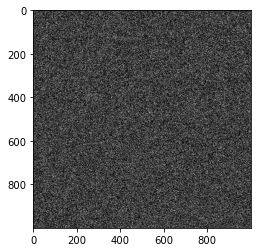

In [20]:
plt.imshow(cover != stego, vmin=0, vmax=1, cmap='gray');

And the LSB planes now look like this. Success!

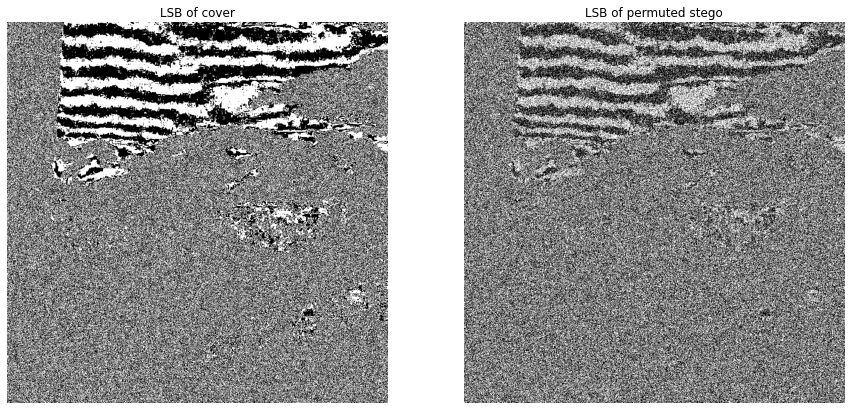

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15), sharey=False)

ax[0].imshow(cover & 1, cmap = "gray");
ax[1].imshow(stego & 1, cmap = "gray");
ax[0].set_title(f'LSB of cover');
ax[1].set_title(f'LSB of permuted stego');
ax[0].axis('off');
ax[1].axis('off');

## Message extraction

In Stego image: Gather LSB bits of pixels along pseudorandom path and convert into characters/letters.

In [22]:
# Gather LSB bits along pseudorandom path
message_bits_extracted = []
for i, it in enumerate(perm): # <- walk along the same pseudorandom path
    # get index (x- and y-coordinate)
    idx = it // stego.shape[1], it % stego.shape[1]
        
    # get message bit
    message_bits_extracted.append(stego[idx] & 1)

    # check end
    if (i + 1) % 8 == 0: # <- if we hit our stop code '00000000'
        if all([b == 0 for b in message_bits_extracted[-8:]]):
            break

In [23]:
# convert to characters
message_bytes_extracted = b''
for i in range(len(message_bits_extracted)//8):
    char_bits = list(message_bits_extracted[i*8:(i+1)*8])

    # decode the byte
    byte = 0
    for i, bit in enumerate(char_bits):
        byte |= bit << i
    message_bytes_extracted += int(byte).to_bytes(1, byteorder='big')

# remove tracing zero
message_extracted = bytes.decode(message_bytes_extracted, 'ascii').split('\0')[0]

In [24]:
message == message_extracted

True

## Take-away messages

- We can hide a message in the LSBs of an image
- Sequential embedding is noticable in homogeneous regions of an image
- Instead: use permuted embedding
- This requires the exchange of a seed/key

In [25]:
import logging
def embed_lsbr(cover, message, key=None): #cover: np.array, message:String
    # encode
    message_bits = []
    for bit in message.encode('ascii') + b'\x00': # <- stop code
        for i in range(8):
            message_bits.append((bit >> i) & 1) # turn characters into 0s and 1s
    message_bits = np.array(message_bits)
    
    # set order
    perm = np.linspace(0, cover.size-1, cover.size, dtype='int64')
    ## permuted walk-through
    if key is not None:
        rng = np.random.default_rng(key) # <- here we choose the seed
        perm = rng.permutation(perm) # <- this shuffles our order around 
    
    # iterate elements
    stego = cover.copy() #copy the cover

    for i, it in enumerate(perm):
        # message exhausted (we are at end of message)
        if len(message_bits) <= i:
            break
        
        # get index (x- and y-coordinate of pixel we want to change)
        idx = it // cover.shape[1], it % cover.shape[1]
    
        # make change
        stego[idx] &= ~0 << 1
        stego[idx] |= message_bits[i]
        
    return stego



def extract_lsbr(stego, key=None):
    # set order
    perm = np.linspace(0, cover.size-1, cover.size, dtype='int64')
    ## permuted walk-through
    if key is not None:
        rng = np.random.default_rng(key) # <- here we choose the seed
        perm = rng.permutation(perm) # <- this shuffles our order around 
        
    message_bits_extracted = []
    for i, it in enumerate(perm): # <- walk along the same pseudorandom path
        # get index (x- and y-coordinate)
        idx = it // stego.shape[1], it % stego.shape[1]
        
        # get message bit
        message_bits_extracted.append(stego[idx] & 1)

        # check end
        if (i + 1) % 8 == 0: # <- if we hit our stop code '00000000'
            if all([b == 0 for b in message_bits_extracted[-8:]]):
                break
        
    # convert to characters
    message_bytes_extracted = b''
    for i in range(len(message_bits_extracted)//8):
        char_bits = list(message_bits_extracted[i*8:(i+1)*8])

        # decode the byte
        byte = 0
        for i, bit in enumerate(char_bits):
            byte |= bit << i
        message_bytes_extracted += int(byte).to_bytes(1, byteorder='big')

    # remove tracing zero
    try:
        message_extracted = bytes.decode(message_bytes_extracted, 'ascii').split('\0')[0]
        return message_extracted
    except UnicodeDecodeError:
        logging.error('can\'t decode message, perhaps wrong key?')
        return None

## Hands-on: LSBr

We put all the code fragments from above into the functions embed_lsbr amd extract_lsbr
- Use the functions embed_lsbr and extract_lsbr to embed your own messages
- What happens if the key does not match?


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.stats
import seaborn as sns
import string
import warnings

im = Image.open('../img/nockspitze.png')  # load image
cover = np.array(im.convert('L'))  # PIL to numpy

stego = embed_lsbr(cover, "Super secret message!")

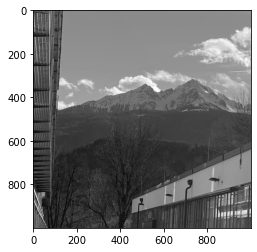

In [27]:
plt.imshow(stego,cmap = "gray");

In [28]:
extract_lsbr(stego)

'Super secret message!'

In [29]:
stego_with_key = embed_lsbr(cover, "Super secret message!", key=1997)

In [30]:
extract_lsbr(stego_with_key)

ERROR:root:can't decode message, perhaps wrong key?


In [31]:
extract_lsbr(stego_with_key, key=1997)

'Super secret message!'

In [32]:
extract_lsbr(stego_with_key, key=19)

ERROR:root:can't decode message, perhaps wrong key?
